In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [4]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1086

주기를 월로 해서 다운로드한다. (2001년 1월~)

외국인 보유금액 : 금융감독원에 투자 등록한 외국인이 취득한 상장 주식의 기준일 현재 시가로 평가한 금액

보유금액 > 유가증권시장 사용

(1) 한달 lag(shift(1)) 한다.
 - 1월의 데이터가 1월 마지막날 데이터이고 2월 1일 리밸런싱시에 사용하기

## 데이터 수정 버전 (2021-11-21)
이전 백테스팅에 사용했던 외국인수급 데이터인 

index.go.kr에서 받은 데이터의 "외국인 보유금액: 금융감독원에 투자 등록한 외국인이 취득한 상장 주식의 기준일 현재 시가로 평가한 금액" 으로 이것은 백테스트와 맞지 않는다.

아래 대신증권에서 받은 "월별투자자별매매동향대신.csv" 로 변경하여 테스트하면 결과가 많이 다르다.

해당 데이터는 투자자별매매동향을 HTS로 부터 받은 다음 cumsum한 후 매월말 데이터를 추출한 것이다.

* 참고 
- 영웅문의 경우 2003년부터 데이터가 존재하고 대신증권의 경우 1998-3-31일 부터 존재한다.

In [5]:
dd = pd.read_csv('월별투자자별매매동향대신.csv', index_col=0, parse_dates=True)

In [6]:
dd['2001':'2021-08']

,개인,외국인,기관계,금융투자,보험,투신,은행,기타금융,연기금등,"국가,지자체",기타법인,사모펀드
일자,,,,,,,,,,,,
2001-01-31,-46479.000,168175.000,-98280.000,-42971.000,-40591.000,44850.000,-60237.000,-1519.000,2351.000,-3104.000,0.000,0.000
2001-02-28,-51755.000,171768.000,-98926.000,-43527.000,-40783.000,44690.000,-61806.000,-1438.000,4095.000,-777.000,0.000,0.000
2001-03-31,-50382.000,172180.000,-102793.000,-44415.000,-42382.000,44195.000,-63966.000,-1174.000,5109.000,1300.000,0.000,0.000
2001-04-30,-57883.000,183415.000,-105795.000,-44652.000,-43382.000,43437.000,-64219.000,-1498.000,4685.000,565.000,0.000,0.000
2001-05-31,-67550.000,193369.000,-110317.000,-44935.000,-43512.000,42737.000,-67307.000,-1484.000,4353.000,4798.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,138921.000,192672.000,-536312.000,210932.000,4332.000,-708778.000,-298859.000,-62570.000,554999.000,188628.000,16580.000,-110993.000
2021-05-31,206216.000,107507.000,-516404.000,231690.000,3221.000,-705375.000,-300600.000,-63753.000,554960.000,188628.000,14283.000,-111162.000
2021-06-30,254374.000,100367.000,-552941.000,218295.000,977.000,-709085.000,-303315.000,-66812.000,552720.000,188628.000,9664.000,-120317.000


In [7]:
외국인수급 = pd.read_csv('data/외국인수급.csv') 
외국인수급 = 외국인수급.set_index('Date').T 
외국인수급.index = pd.to_datetime(외국인수급.index, format="%Y%m월")
# 외국인수급 =
# 외국인수급.resample('D').first().fillna(method='ffill')[['유가증권시장']]
외국인수급 = 외국인수급[['유가증권시장']] 
외국인수급.columns = ['kospi']
외국인수급['kospi'] = 외국인수급['kospi'].astype('float') 
외국인수급 = 외국인수급.shift(1) # --- (1)
외국인수급

,kospi
2001-01-01,NaN
2001-02-01,81.800
2001-03-01,76.000
2001-04-01,70.700
2001-05-01,80.700
...,...
2021-04-01,766.500
2021-05-01,783.000
2021-06-01,779.400
2021-07-01,799.500


<AxesSubplot:>

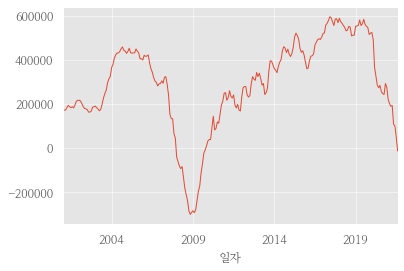

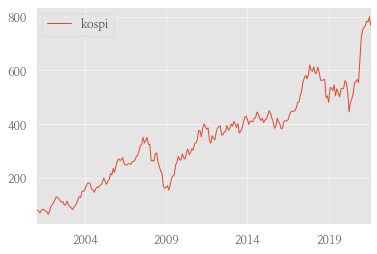

In [8]:
ax = dd.loc['2001':'2021-08', '외국인'].plot()
외국인수급.plot()

위의 두 차트를 보았을때 두번째 그림이 이전 백테스팅에 사용했던 데이터 인데 이 경우 외국인이 보유한 주식수에 현재 가격을 반영한 것이라 일반적인 매매대금의 순매수 금액과 차이가 난다.

위 그래프중 첫번째 그래프가 정확히 우리가 다루어야 할 데이터이다.

In [9]:
외국인수급 = dd.loc['2001':'2021-08', '외국인'].copy().to_frame()
외국인수급.columns = ['kospi']

In [10]:
외국인수급 = 외국인수급.resample('MS').first().shift(1)

In [11]:
외국인수급['1m'] = 외국인수급['kospi'].pct_change(1) 
외국인수급['2m'] = 외국인수급['kospi'].pct_change(1).shift(1) 
외국인수급['3m'] = 외국인수급['kospi'].pct_change(1).shift(2) 
외국인수급

,kospi,1m,2m,3m
일자,,,,
2001-01-01,NaN,NaN,NaN,NaN
2001-02-01,168175.000,NaN,NaN,NaN
2001-03-01,171768.000,0.021,NaN,NaN
2001-04-01,172180.000,0.002,0.021,NaN
2001-05-01,183415.000,0.065,0.002,0.021
...,...,...,...,...
2021-04-01,188957.000,-0.062,-0.093,-0.193
2021-05-01,192672.000,0.020,-0.062,-0.093
2021-06-01,107507.000,-0.442,0.020,-0.062


 >외국인 코스피 수급을 이용하여 직전 3개월 **연속** 상승시 100%, 2개월 연속 상승시 66%, 1개월 연속 상승시 33% 비중으로 스위칭

블로그 문서대로 라면 아래처럼 계산해야 한다.

In [12]:
연속3개월 = ((외국인수급['3m'] > 0) & (외국인수급['2m'] > 0) & (외국인수급['1m'] > 0)) 
연속2개월 = ((외국인수급['2m'] > 0) &(외국인수급['1m'] > 0)) 
연속1개월 = (외국인수급['1m'] > 0)
target_weights = pd.DataFrame(np.where(연속3개월, 1.0, 
                                np.where(연속2개월, 0.66, 
                                    np.where(연속1개월, 0.33, 0))),
                            index=외국인수급.index, 
                            columns=['ams']) 
target_weights.head(20)

,ams
일자,
2001-01-01,0.000
2001-02-01,0.000
2001-03-01,0.330
2001-04-01,0.660
2001-05-01,1.000
2001-06-01,1.000
2001-07-01,0.000
2001-08-01,0.000
2001-09-01,0.330


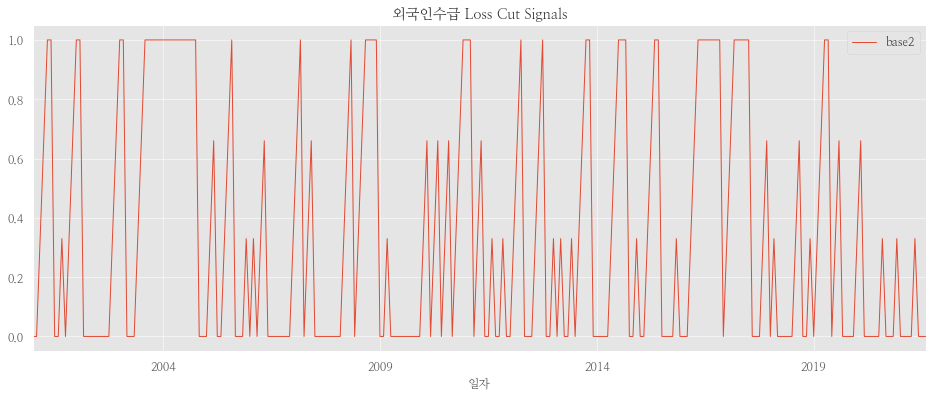

In [13]:
target_weights['현금'] = 1.0 - target_weights
target_weights.columns = ['base2', '현금'] 
# target_weights.to_csv('한국Base2비중.csv')
target_weights['base2'].plot(figsize=(16,6), title='외국인수급 Loss Cut Signals', legend=True);

In [14]:
tickers = list(prices.columns[:-4])+['현금'] 
print(tickers)

['MKF500', '에너지', '화학', '금속및광물', '기타 소재', '건설', '조선', '기타자본재', '상업서비스', '운송', '자동차및부품', '내구소비재및의류', '소비자서비스', '미디어', '유통', '음식료및담배', '생활용품', '의료', '은행', '보험', '증권', '기타금융', '소프트웨어', '하드웨어', '반도체', '디스플레이', '통신서비스', '유틸리티', '코스피200', '코스닥', '현금']


In [15]:
base2 = bt.Strategy(
    'base2', 
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(), bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0)),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance() 
    ] 
)
# %%
bt_id2 = bt.Backtest(base2, prices) 
r_id2 = bt.run(bt_id2)

In [16]:
kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
# %%
bt_kbase2 = bt.Backtest(kbase2, prices) 
r = bt.run(bt_id2, bt_kbase2)

In [17]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 base2       kbase2
-------------------  ----------  ----------
Start                2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%

Total Return         913.59%     238.90%
Daily Sharpe         0.49        0.44
Daily Sortino        0.76        0.66
CAGR                 13.40%      6.85%
Max Drawdown         -57.72%     -34.98%
Calmar Ratio         0.23        0.20

MTD                  1.93%       0.01%
3m                   32.71%      0.50%
6m                   20.24%      -1.64%
YTD                  19.84%      -1.74%
1Y                   17.71%      -3.34%
3Y (ann.)            -1.04%      -2.74%
5Y (ann.)            0.32%       1.92%
10Y (ann.)           8.81%       7.64%
Since Incep. (ann.)  13.40%      6.85%

Daily Sharpe         0.49        0.44
Daily Sortino        0.76        0.66
Daily Mean (ann.)    11.41%      5.30%
Daily Vol (ann.)     23.37%      12.09%
Daily Skew           -0.08       0.28
Dai

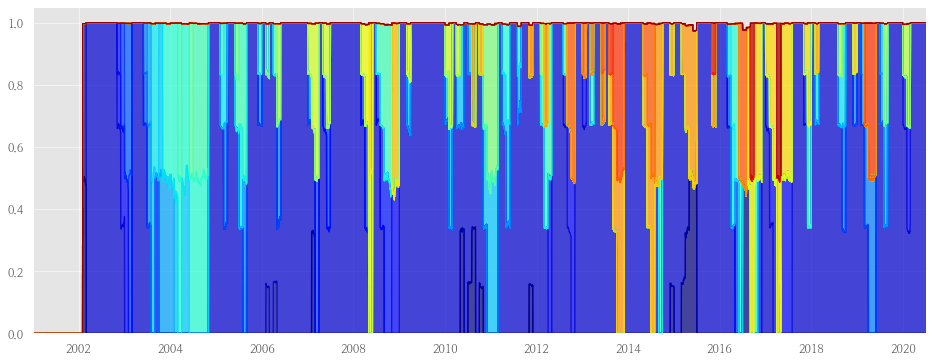

In [18]:
r.get_security_weights('kbase2').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

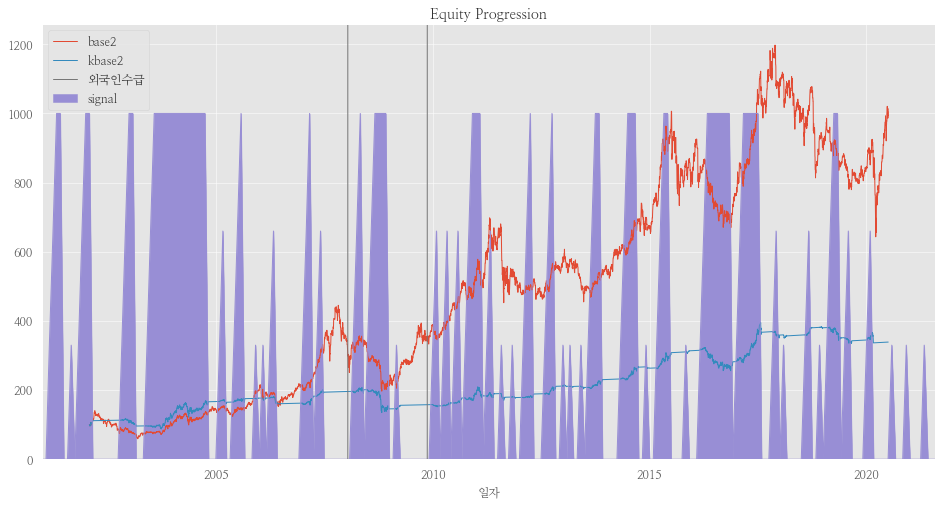

In [19]:
ax = r.plot(figsize=(16,8));
(target_weights['base2']*1000).plot.area(ax=ax, label='signal');
(외국인수급['kospi']*10).plot(ax=ax, label='외국인수급');
plt.legend(loc="upper left");

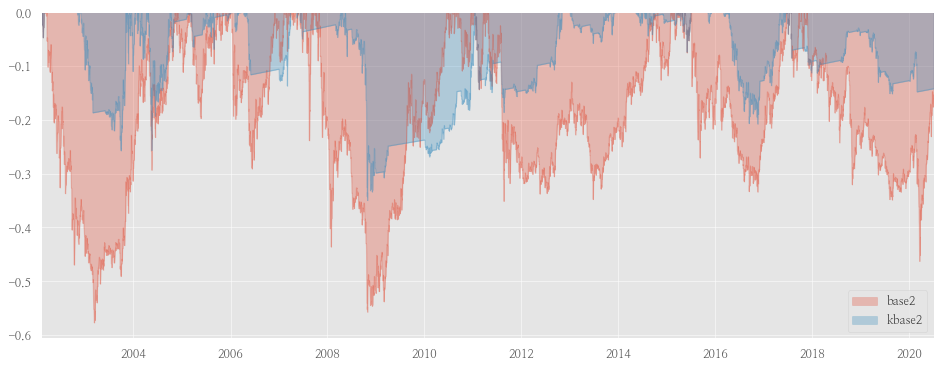

In [20]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

In [21]:
# bt_kbase2.positions.to_csv('한국ID2상대모멘텀_포지션.csv')